In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import os
import re
import collections  # returns frequencies 

In [49]:
# display more than one record in cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Dark mode display 
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [50]:
# Pull data coming in Funding Projects KS 
ks_proj2016 = pd.read_csv('ks-projects-201612.csv', encoding = "ISO-8859-1")
ks_proj2018 = pd.read_csv('ks-projects-201801.csv')
ks_proj2016.shape
ks_proj2018.shape
ks_proj2016.head()

(323750, 17)

(378661, 15)

ID                                               name   \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000004038                                     Where is Hank?   
2  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
3  1000011046  Community Film Project: The Art of Neighborhoo...   
4  1000014025                               Monarch Espresso Bar   

        category  main_category  currency             deadline   goal   \
0          Poetry     Publishing       GBP  2015-10-09 11:36:00   1000   
1  Narrative Film   Film & Video       USD  2013-02-26 00:20:50  45000   
2           Music          Music       USD  2012-04-16 04:24:11   5000   
3    Film & Video   Film & Video       USD  2015-08-29 01:00:00  19500   
4     Restaurants           Food       USD  2016-04-01 13:38:27  50000   

             launched  pledged       state  backers  country  usd pledged   \
0  2015-08-11 12:12:28        0      failed        0       GB            0   
1  2013-01-12 00:20:50      220      failed        3       US          220   
2  2012-03-17 03:24:11        1      failed        1       US            1   
3  2015-07-04 08:35:03     1283    canceled       14       US         1283   
4  2016-02-26 13:38:27    52375  successful      224       US        52375   

  Unnamed: 13 Unnamed: 14 Unnamed: 15  Unnamed: 16  
0         NaN         NaN         NaN          nan  
1         NaN         NaN         NaN          nan  
2         NaN         NaN         NaN          nan  
3         NaN         NaN         NaN          nan  
4         NaN         NaN         NaN          nan

In [51]:
pd.options.display.float_format = '{:.2f}'.format

In [52]:
# stripe out lead and trailing spaces from columns 
xcols = [x.strip() for x in ks_proj2016.columns]
ks_proj2016.columns = xcols
ks_proj2016.columns
ks_proj2016.dtypes

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')

ID                 int64
name              object
category          object
main_category     object
currency          object
deadline          object
goal              object
launched          object
pledged           object
state             object
backers           object
country           object
usd pledged       object
Unnamed: 13       object
Unnamed: 14       object
Unnamed: 15       object
Unnamed: 16      float64
dtype: object

In [53]:
# Formating: convert goal, pledged, backers, and usd pledged to numbers 
ks_proj2016['goal'] = pd.to_numeric(ks_proj2016.goal, errors='coerce')
ks_proj2016['pledged'] = pd.to_numeric(ks_proj2016.pledged, errors='coerce')
ks_proj2016['usd pledged'] = pd.to_numeric(ks_proj2016['usd pledged'], errors='coerce')
ks_proj2016['backers'] = pd.to_numeric(ks_proj2016.backers, errors='coerce')
ks_proj2016[['goal','pledged','usd pledged','backers']].dtypes

goal           float64
pledged        float64
usd pledged    float64
backers        float64
dtype: object

In [65]:
# Format dates and grab time duration 
ks_proj2016.launched = pd.to_datetime(ks_proj2016.launched)
ks_proj2016.deadline = pd.to_datetime(ks_proj2016.deadline)
ks_proj2016.dtypes

ID                        int64
name                     object
category                 object
main_category            object
currency                 object
deadline         datetime64[ns]
goal                    float64
launched         datetime64[ns]
pledged                 float64
state                    object
backers                 float64
country                  object
usd pledged             float64
avg_pledge              float64
pledgedvgoal            float64
outcome                   int32
dtype: object

In [55]:
# Columns "Unnamed 13" ... "Unnamed: 16" are due to data processing issue
    # Multiple rows where name mistakenly expanded out.  
len(ks_proj2016[ks_proj2016["Unnamed: 13"].notnull()])   # 625 / 320k rows affected. For simplicity will remove these rows.
ks_proj2016 = ks_proj2016[ks_proj2016["Unnamed: 13"].isnull()] # remove rows with extraneous values 
ks_proj2016.iloc[1450:1455,13:17].head()  # check on record 1454 (one of the affected columns) 

# remove Unnamed columns: no longer contain any numbers   
ks_proj2016 = ks_proj2016.drop(ks_proj2016.columns[13:17],axis=1)

625

Unnamed: 13 Unnamed: 14 Unnamed: 15  Unnamed: 16
1450         NaN         NaN         NaN          nan
1451         NaN         NaN         NaN          nan
1452         NaN         NaN         NaN          nan
1453         NaN         NaN         NaN          nan
1455         NaN         NaN         NaN          nan

In [10]:
# Category research: create second just for fashion 
ks_proj2016.main_category.value_counts()

Film & Video    57665
Music           46722
Publishing      34221
Games           28005
Technology      26116
Art             23959
Design          23865
Food            21198
Fashion         18382
Theater          9962
Photography      9664
Comics           8743
Crafts           7182
Journalism       4069
Dance            3372
Name: main_category, dtype: int64

In [57]:
#---- RESPONSE Varibles: Proessing 
    # Candidate variables: 1. no. of backers  2. Status (failed or not: 0 or 1), 3. avg. pledge by backer 4. pledgevgoal 
        # avg plegdge: if backers = 0, set value to 0 
avg_pledge = np.where(ks_proj2016['backers']==0, 0, ks_proj2016['usd pledged'] / ks_proj2016['backers'])
stats.describe(avg_pledge)
ks_proj2016["avg_pledge"] = avg_pledge 

DescribeResult(nobs=323125, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)

In [58]:
        # pledged vs. goal 
print("usd pledge is null", len(ks_proj2016[ks_proj2016["usd pledged"].isnull()]))  # null numerator
print("num goal is null", len(ks_proj2016[ks_proj2016["goal"].isnull()]))
pledgedvgoal = np.where(ks_proj2016["usd pledged"].isnull(), 0, ks_proj2016['usd pledged'] / ks_proj2016['goal'])
stats.describe(pledgedvgoal)  # many N/A's.    
print("median of pledgedvgoal", np.percentile(pledgedvgoal, 50))
ks_proj2016["pledgedvgoal"] = pledgedvgoal
ks_proj2016.goal.describe()
pledgedvgoal[0:5]

usd pledge is null 3797
num goal is null 7


DescribeResult(nobs=323125, minmax=(0.0, 55266.57), mean=2.610217814872047, variance=30920.224751350874, skewness=190.13349245746394, kurtosis=46356.56195746872)

median of pledgedvgoal 0.1043285936


count      323118.00
mean        47152.52
std       1139577.48
min             0.01
25%          2000.00
50%          5000.00
75%         15000.00
max     100000000.00
Name: goal, dtype: float64

array([0.00000000e+00, 4.88888889e-03, 2.00000000e-04, 6.57948718e-02,
       1.04750000e+00])

In [59]:
    # Status: State value counts 
ks_proj2016.state.value_counts()

failed        168221
successful    113081
canceled       32354
live            4428
undefined       3555
suspended       1479
0                  3
3280               1
6323               1
2503               1
7470               1
Name: state, dtype: int64

In [60]:
    # State: create field "Status" 
        # remove live, undefined, and those with numbers .
ks_proj2016 = ks_proj2016[ks_proj2016['state'].isin(['failed','successful','canceled','suspended','undefined'])]
len(ks_proj2016)

318690

In [14]:
# State: Evaluate which states to keep 
print("stats for canceled")
ks_proj2016.pledgedvgoal[ks_proj2016['state']=='canceled'].describe()  # median close to 0 with massive outliers 
print("stats for suspended")
ks_proj2016.pledgedvgoal[ks_proj2016['state']=='suspended'].describe()  # designate as fail
print("stats for undefined")
ks_proj2016.pledgedvgoal[ks_proj2016['state']=='undefined'].describe()  # all zeroes: remove  
ks_proj2016 = ks_proj2016[ks_proj2016['state'].isin(['failed','successful','canceled','suspended'])]

stats for canceled


count   32354.00
mean        1.42
std       118.73
min         0.00
25%         0.00
50%         0.01
75%         0.08
max     16283.38
Name: pledgedvgoal, dtype: float64

stats for suspended


count   1479.00
mean       1.52
std       17.80
min        0.00
25%        0.00
50%        0.01
75%        0.25
max      560.40
Name: pledgedvgoal, dtype: float64

stats for undefined


count   3555.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: pledgedvgoal, dtype: float64

In [61]:
# --- RESPONSE Variable Status: Designate 'successful' as 1, everything else as 0
status = np.where(ks_proj2016['state'] == 'successful', 1, 0)
collections.Counter(status)
    # add Status to datafreame 
ks_proj2016['outcome'] = status

Counter({0: 205609, 1: 113081})

In [66]:
# Launch month Analysis : Create Field
launch_month = ks_proj2016['launched'].dt.month
ks_proj2016['launch_month'] = launch_month

outcome           0      1  success_perc
launch_month                            
1             15356   7859          0.34
2             16153   9500          0.37
3             17853  10792          0.38
4             17379  10444          0.38
5             17730  10298          0.37
6             17926  10128          0.36
7             21905  10178          0.32
8             18669   9212          0.33
9             17292   9636          0.36
10            17997  10407          0.37
11            15879   8867          0.36
12            11470   5760          0.33

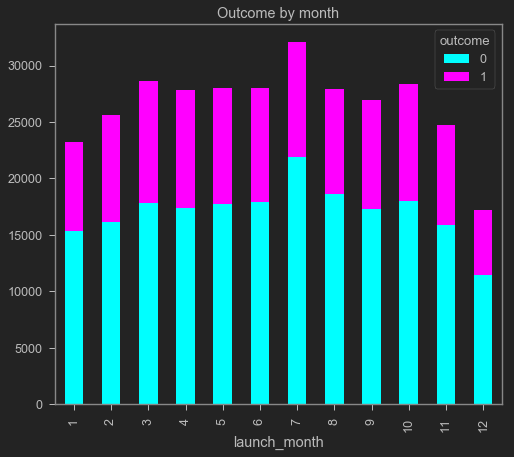

In [67]:
# Launch month: find average outcome: success/failure
launch_pivot = pd.pivot_table(ks_proj2016, index='launch_month',values='outcome', aggfunc=np.mean)
launch_outcome = pd.crosstab(ks_proj2016.launch_month, ks_proj2016.outcome)
launch_outcome['success_perc'] = launch_pivot.outcome
launch_outcome[launch_outcome.columns[0:2]].plot(kind='bar', 
            stacked=True, color=['cyan', 'magenta'], grid=False, title='Outcome by month')
launch_outcome

pandas.core.frame.DataFrame

Text(0.5, 1.0, 'Average Pledge/Backer by Launch Month')

launch_month  avg_pledge
0              1       56.95
1              2       62.18
2              3       64.72
3              4       63.58
4              5       66.29
5              6       62.73
6              7       51.27
7              8       53.30
8              9       58.68
9             10       58.86
10            11       64.61
11            12       62.77

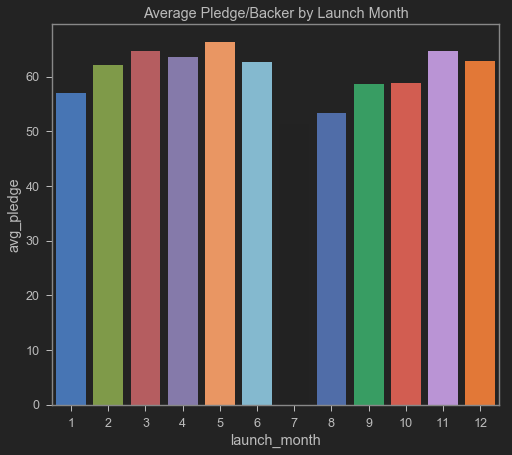

In [68]:
# launch month: see average pledge 
launch_pivot_ap = pd.pivot_table(ks_proj2016, index='launch_month',values='avg_pledge', aggfunc=np.mean).reset_index()
type(launch_pivot_ap)
sns.barplot(x='launch_month', y = 'avg_pledge', 
            data=launch_pivot_ap).set_title("Average Pledge/Backer by Launch Month")
launch_pivot_ap

num records in main category: Fashion 18049


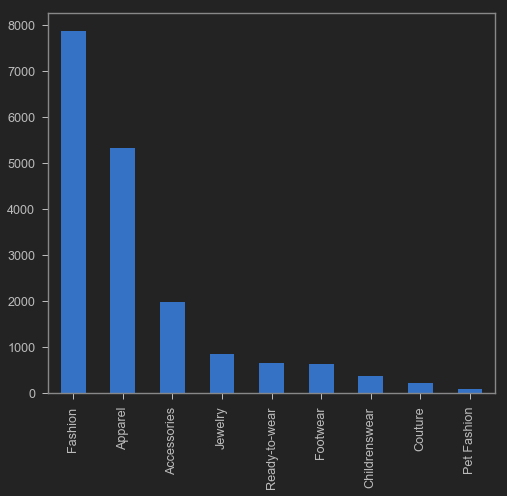

In [69]:
# create df just for fashion 
ks_fash = ks_proj2016[ks_proj2016.main_category=='Fashion']
ks_fash.category.value_counts().plot(kind='bar')
print("num records in main category: Fashion", len(ks_fash))

In [70]:
# investigate categories not in Fashion main category: remove any fodos 
print("Vegan: Value counts", ks_proj2016[ks_proj2016.category=='Vegan'].main_category.value_counts()) 
print("Small Batch", ks_proj2016[ks_proj2016.category=='Small Batch'].main_category.value_counts() ) 
    # all food: remove from oe_category list 
print("Textiles", ks_proj2016[ks_proj2016.category=='Textiles'].main_category.value_counts())   #art: keep 
print("Quilts", ks_proj2016[ks_proj2016.category=='Quilts'].main_category.value_counts())   #Crafts: keep 
print("Knitting", ks_proj2016[ks_proj2016.category=='Knitting'].main_category.value_counts())    #Crafts: keep 
print("Product Design", ks_proj2016[ks_proj2016.category=='Product Design'].main_category.value_counts())   #Design: keep 

Vegan: Value counts Food    414
Name: main_category, dtype: int64
Small Batch Food    1427
Name: main_category, dtype: int64
Textiles Art    194
Name: main_category, dtype: int64
Quilts Crafts    69
Name: main_category, dtype: int64
Knitting Crafts    150
Name: main_category, dtype: int64
Product Design Design    17036
Name: main_category, dtype: int64


Num of records in Orelse Category:  38711


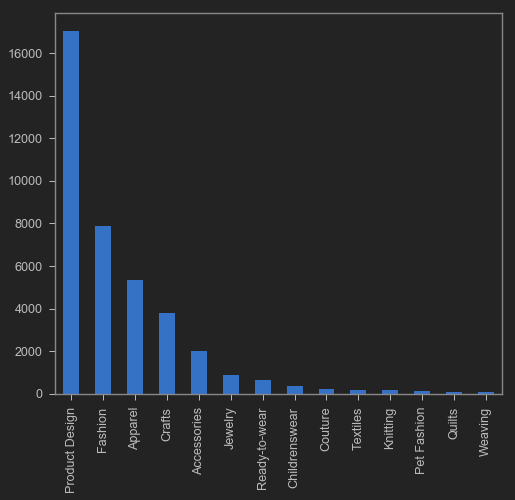

In [71]:
# Edit Orelse category list 
oe_cat = ['Apparel','Accessories','Childrenswear','Couture', 'Crafts', 'Fashion', 'Jewelry',
          'Knitting','Pet Fashion', 'Product Design', 'Quilts','Ready-to-wear','Textiles', 'Weaving']
ks_oe = ks_proj2016[ks_proj2016.category.isin(oe_cat)]
print("Num of records in Orelse Category: ", len(ks_oe))
ks_oe.category.value_counts().plot(kind='bar')

outcome          0     1  success_perc
launch_month                          
1             2054   718          0.26
2             2166   806          0.27
3             2393   980          0.29
4             2197   930          0.30
5             2276   896          0.28
6             2498   975          0.28
7             2689   995          0.27
8             2437   891          0.27
9             2396  1029          0.30
10            2565  1204          0.32
11            2355  1086          0.32
12            1567   608          0.28

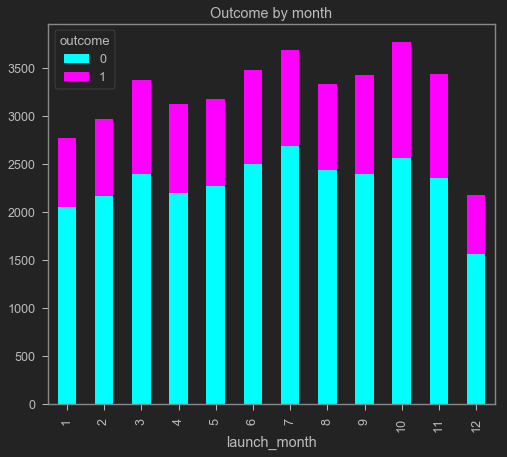

In [72]:
# check launch month for fashion categories: See Average PLedge 
launch_pivot = pd.pivot_table(ks_oe, index='launch_month',values='outcome', aggfunc=np.mean)
launch_outcome = pd.crosstab(ks_oe.launch_month, ks_oe.outcome)
launch_outcome['success_perc'] = launch_pivot.outcome
launch_outcome[launch_outcome.columns[0:2]].plot(kind='bar', 
            stacked=True, color=['cyan', 'magenta'], grid=False, title='Outcome by month')
launch_outcome   # Note  Lower outcome rates for Orelse categories

pandas.core.frame.DataFrame

Text(0.5, 1.0, 'Average Pledge/Backer by Launch Month')

launch_month  avg_pledge
0              1       60.33
1              2       69.88
2              3       74.84
3              4       72.30
4              5       78.67
5              6       70.23
6              7       56.49
7              8       58.17
8              9       63.66
9             10       67.18
10            11       80.25
11            12       76.98

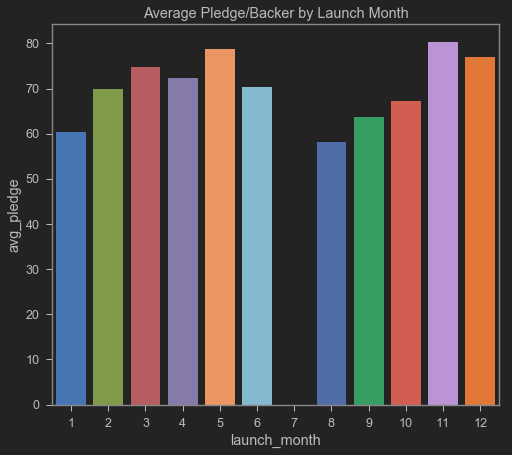

In [73]:
# launch month for Orelse categories : see average pledge 
launch_pivot_ap = pd.pivot_table(ks_oe, index='launch_month',values='avg_pledge', aggfunc=np.mean).reset_index()
type(launch_pivot_ap)
sns.barplot(x='launch_month', y = 'avg_pledge', 
            data=launch_pivot_ap).set_title("Average Pledge/Backer by Launch Month")
launch_pivot_ap